In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [191]:
seed = 42

# Data preparation

In [192]:
def clean_df(df):
    return df

def prep_features(df: pd.DataFrame):
    df = df.drop(["id", "class"], axis=1, errors='ignore')

    df["pixels"] = df["pixels"].apply(eval)

    pixel_cols = pd.DataFrame(df["pixels"].tolist())
    pixel_cols.columns = [f"pixel_{i}" for i in range(4096)]
    
    df = pd.concat([df.drop(["pixels"], axis=1), pixel_cols], axis=1)

    return df

In [193]:
df = pd.read_csv("train_data.csv", dtype={"id": str})
df = clean_df(df)

df_train = prep_features(df)

In [194]:
df_train.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,...,-0.900701,-0.860981,-0.689252,-0.733645,-0.566589,-0.440421,-0.400701,-0.574766,-0.662383,-0.434579
1,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,...,-0.900701,-0.860981,-0.689252,-0.733645,-0.566589,-0.440421,-0.400701,-0.574766,-0.662383,-0.434579
2,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,...,-0.900701,-0.860981,-0.689252,-0.733645,-0.566589,-0.440421,-0.400701,-0.574766,-0.662383,-0.434579
3,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,...,-0.900701,-0.860981,-0.689252,-0.733645,-0.566589,-0.440421,-0.400701,-0.574766,-0.662383,-0.434579
4,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,-0.100467,...,-0.900701,-0.860981,-0.689252,-0.733645,-0.566589,-0.440421,-0.400701,-0.574766,-0.662383,-0.434579


# Exploratory Data Analysis

In [195]:
X = df_train
global_mean_vector = X.mean(axis=0)

X_centered = X - global_mean_vector

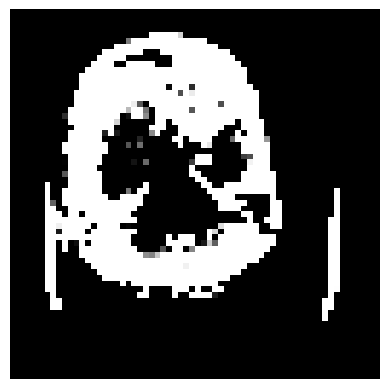

In [196]:
image = X_centered.iloc[420].filter(like="pixel_").values.reshape((64, 64))

plt.imshow(image, cmap="gray", vmin=0, vmax=1)
plt.axis("off") 
plt.show()

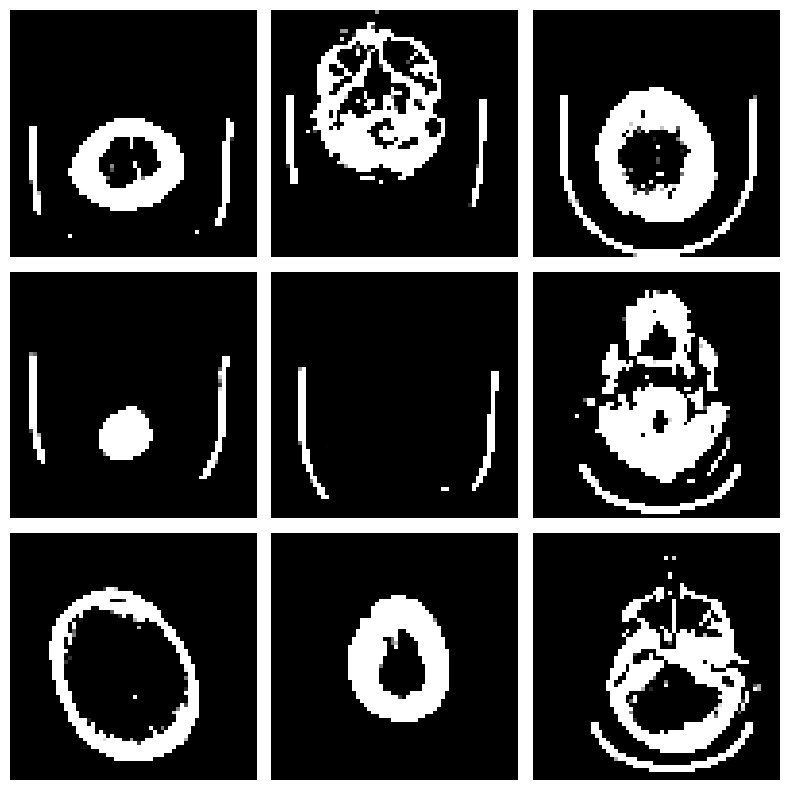

In [197]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = X_centered.iloc[i].filter(like="pixel_").values.reshape((64, 64))
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.axis("off") 

plt.tight_layout()
plt.show()

# Models

In [198]:
X_train, X_val, y_train, y_val = train_test_split(
    X_centered, df["class"], test_size=0.2, random_state=seed
)

In [199]:
def evaluate(clf):
    scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=3, n_jobs=-1)
    return scores.mean() - scores.std()

In [200]:
svm = SVC(C=5)

evaluate(svm)

0.3230529376020765

In [201]:
mlp = MLPClassifier(hidden_layer_sizes=(16, 8), random_state=seed)

evaluate(mlp)

0.32358958042440666

In [202]:
clf = svm

clf.fit(X_train, y_train)

SVC(C=5)

# Submission

In [203]:
df_test = pd.read_csv("test_data.csv", dtype={"id": str})
df_test = clean_df(df_test)
features = prep_features(df_test)

In [204]:
# subtask 1
X_test_centered = features - global_mean_vector

# # subtask 2
subtask2 = clf.predict(X_test_centered)

In [205]:
np.set_printoptions(threshold=1000)
subtask1_rows = []
for idx, row in X_centered.iterrows():
    centered_pixels = row.values
    subtask1_rows.append((
            1,
            df.iloc[idx]["id"],
            centered_pixels,
    ))

subtask2_rows = []
for idx, pred in enumerate(subtask2):
    subtask2_rows.append((
         2,
        df_test.iloc[idx]["id"],
        int(pred),
    ))

submission = pd.DataFrame(
    subtask1_rows + subtask2_rows, columns=["subtaskID", "datapointID", "answer"]
)
submission.head()

,subtaskID,datapointID,answer
0,1,015002,"[-0.10046728971962618, -0.10046728971962618, -..."
1,1,015003,"[-0.10046728971962618, -0.10046728971962618, -..."
2,1,015006,"[-0.10046728971962618, -0.10046728971962618, -..."
3,1,015010,"[-0.10046728971962618, -0.10046728971962618, -..."
4,1,015011,"[-0.10046728971962618, -0.10046728971962618, -..."


In [206]:
submission.to_csv("submission.csv", index=False)